In [177]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [178]:
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

REBUILD_DATA = False

In [179]:
class DogvCat:
    def __init__(self):
        self.IMG_SIZE = 50
        self.CATS = os.path.join('data', 'training_set', 'cats')
        self.DOGS = os.path.join('data', 'training_set', 'dogs')
        self.LABELS = {self.CATS: 0, self.DOGS: 1}
    
        self.training_data = []
        self.cat_count = 0
        self.dog_count = 0

    def load_images(self):
        for label in self.LABELS:
            print(label)
            # for _, _, img_files in os.walk(label):
            
            for img_files in tqdm(os.listdir(label)):
                path = os.path.join(label, img_files)
                
                # img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                # img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                
                img = Image.open(path)
                transform = transforms.Compose([
                    transforms.Grayscale(),
                    transforms.Resize((self.IMG_SIZE, self.IMG_SIZE)),
                ])
                img = transform(img)
                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                if label == self.CATS:
                    self.cat_count += 1
                elif label == self.DOGS:
                    self.dog_count += 1

    def save_training_data(self):
        np.random.shuffle(self.training_data)
        self.training_data = np.array(self.training_data, dtype=object)
        np.save('train.npy', self.training_data)
        print(f'Cats: {self.cat_count}')
        print(f'Dogs: {self.dog_count}')
        

In [180]:
if REBUILD_DATA:
    obj = DogvCat()
    obj.load_images()
    obj.save_training_data()

In [181]:
train_data = np.load('train.npy', allow_pickle=True)

In [182]:
train_data.shape

(8005, 2)

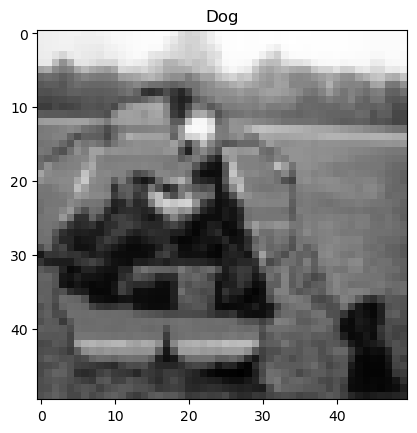

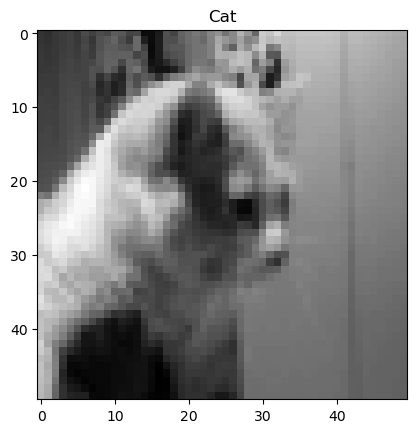

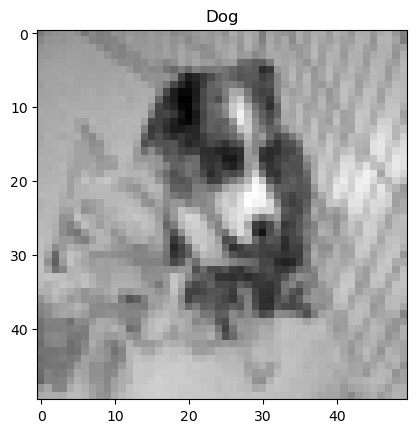

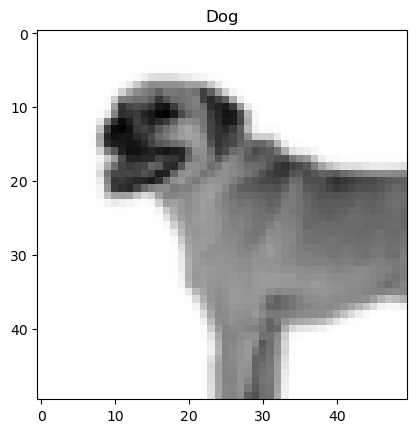

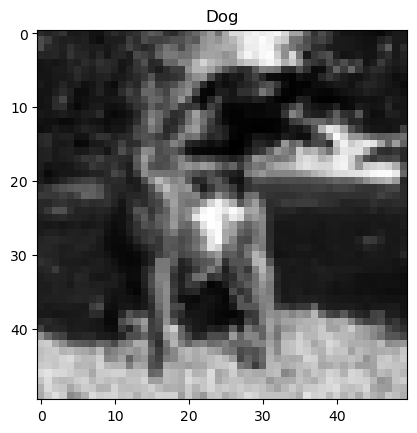

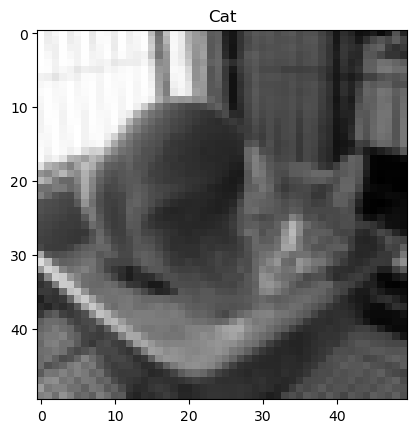

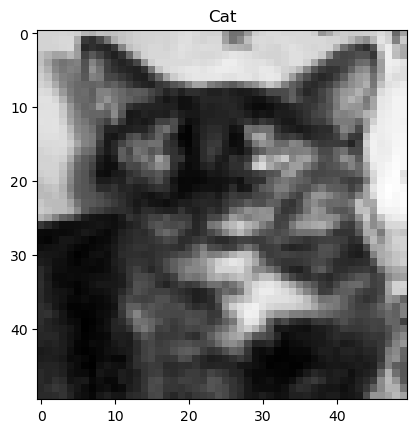

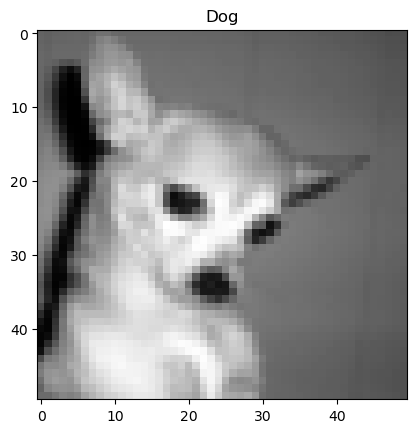

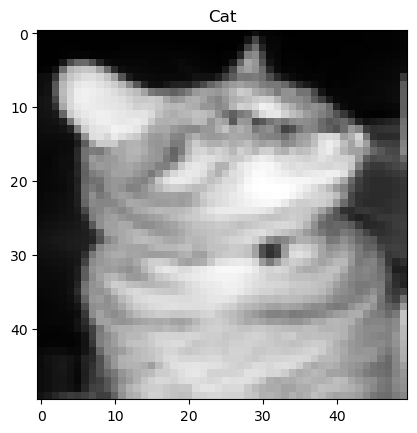

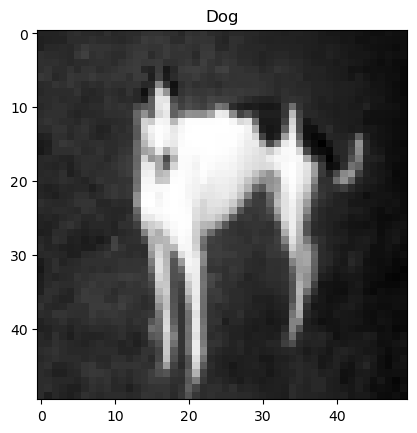

In [183]:
n = torch.randint(low=0, high=8005, size=(10,1))
for i in n:
    plt.imshow(train_data[i][0], cmap="gray")
    title = 'Dog' if train_data[i][1][0] == 0 else 'Cat'
    plt.title(title)
    plt.show()

In [217]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        IMG_SIZE = 50
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5)

        x = torch.randn(IMG_SIZE, IMG_SIZE).view(-1, 1, 50, 50)
        self._to_linear = None     # 128*2*2
        self.convs(x)

        self.dense1 = nn.Linear(self._to_linear, 512)
        self.dense2 = nn.Linear(512, 2)

    def convs(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, (2, 2))
        
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, (2, 2))
        
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, (2, 2))

        if self._to_linear is None:
            self._to_linear = torch.flatten(x).shape[0]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = nn.functional.relu(self.dense1(x))
        x = nn.functional.softmax(self.dense2(x), dim=1)
        return x

In [218]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [186]:
X = torch.Tensor([i[0] for i in train_data]).view(-1, 50, 50)
X = (X - X.mean()) / X.std() # z-score normalization
y = torch.Tensor([i[1] for i in train_data])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [187]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5603, 50, 50]),
 torch.Size([2402, 50, 50]),
 torch.Size([5603, 2]),
 torch.Size([2402, 2]))

In [206]:
def train(model):
    batch_size = 8
    epochs = 5
    for epoch in range(epochs):
        for i in tqdm(range(0, len(X_train), batch_size)):
            # print(i, i + batch_size)
            X_batch = X_train[i:i+batch_size].view(-1, 1, 50, 50).to(device)
            y_batch = y_train[i:i+batch_size].to(device)
    
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
        
    print(loss)

In [207]:
def test(model):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i in tqdm(range(len(X_test))):
            real_class = torch.argmax(y_test[i])
            model_output = model(X_test[i].view(-1, 1, 50, 50).to(device))[0]
            class_prediction = torch.argmax(model_output)
            if class_prediction == real_class:
                correct += 1
            total += 1
    
    acc = correct / total
    print(f'Accuracy: {round(acc, 3)}')

In [208]:
train(model)

100%|███████████████████████████████████████████████████████████████████████████████| 701/701 [00:03<00:00, 199.64it/s]

tensor(0.7007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [209]:
test(model)

100%|█████████████████████████████████████████████████████████████████████████████| 2402/2402 [00:05<00:00, 438.74it/s]

Accuracy: 0.492


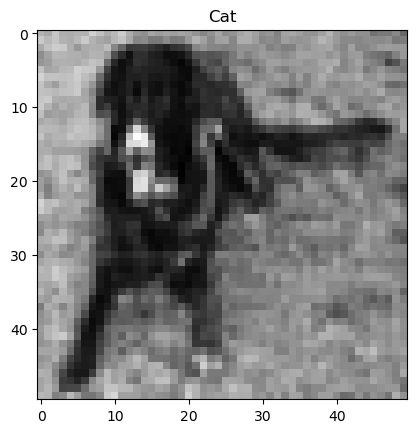

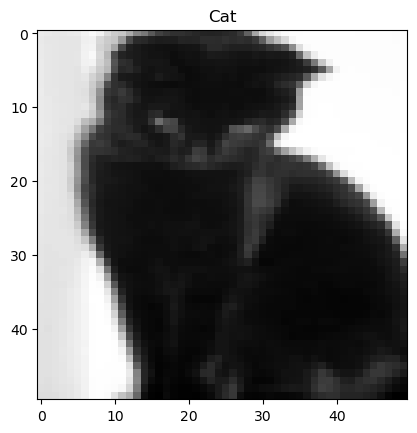

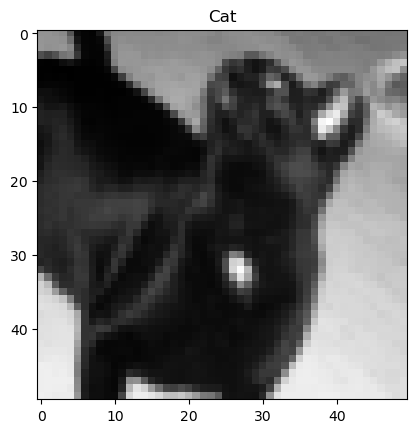

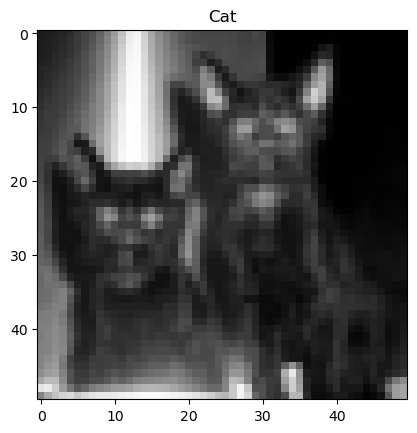

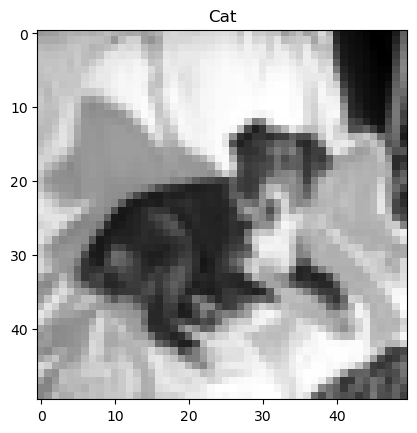

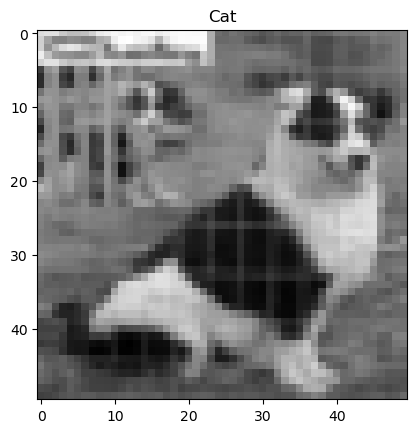

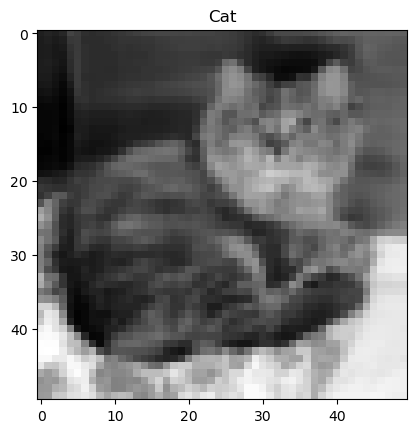

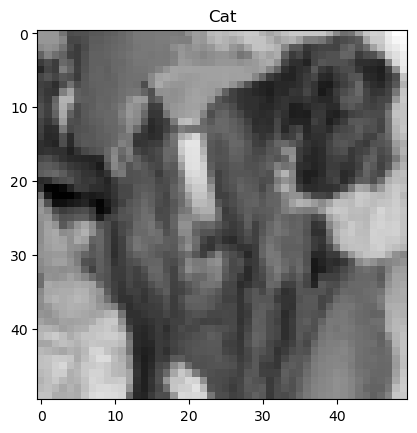

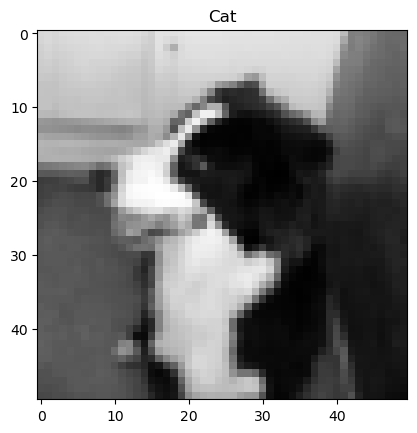

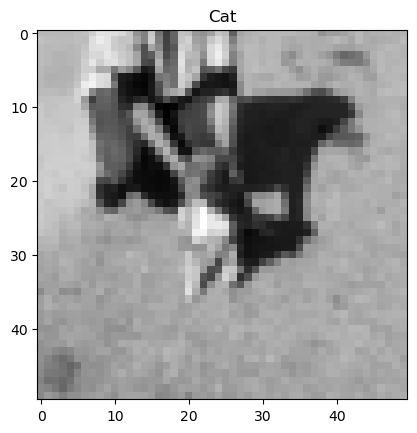

In [214]:
n = torch.randint(low=0, high=2402, size=(10,1))
X_test = X_test.cpu()
for i in n:
    plt.imshow(X_test[i][0], cmap="gray")
    model_output = model(X_test[i].view(-1, 1, 50, 50).to(device))[0]
    class_prediction = torch.argmax(model_output)
    title = 'Dog' if class_prediction == 0 else 'Cat'
    plt.title(title)
    plt.show()